##### Imports

In [1]:
from  asvFormula.classesSizes.recursiveFormula import *
from asvFormula.bayesianNetworks.bayesianNetwork import *
from asvFormula.bayesianNetworks import networkSamplesPath
from asvFormula.datasetManipulation import *
import pandas as pd
from typing import List
import numpy as np
import random 
from pgmpy.readwrite import BIFReader
from pgmpy.inference import VariableElimination
import random
import shap
import sys,os

from sklearn.preprocessing import LabelEncoder

### Auxiliary Functions

In [2]:
printEnabled = True
def disablePrint():
    global printEnabled
    if printEnabled:
        sys._jupyter_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        printEnabled = False

def enablePrint():
    global printEnabled
    printEnabled = True
    sys.stdout.close()
    sys.stdout = sys._jupyter_stdout

def convertDictToCsv(dict, filename):

    df = pd.DataFrame.from_dict(dict, orient='index')

    # Save the DataFrame to a CSV file
    df.to_csv(filename)

## Running ASV in Python

#### Train the decision tree model

In [3]:
random.seed(10)

cancerNetworkPath = networkSamplesPath + "/cancer.bif"
#cancerNetworkPath = networkSamplesPath + "/cancer_tree.bif"

BNmodel = BIFReader(cancerNetworkPath).get_model()

variableToPredict = "Pollution"
treeMaxDepth = 3
# Create a BNDatabaseGenerator object from the model
dataFromBN = datasetFromBayesianNetwork(BNmodel, 2000)

BNmodel.remove_node(variableToPredict) # We remove the variable to predict from the BN model so that we won't have this information when we are going to predict it
BNInference = VariableElimination(BNmodel)

featureColumns = list(dataFromBN.columns)
featureColumns.remove(variableToPredict)  
valuesPerFeature, encodedDataset = encodeCategoricalColumns(dataFromBN)
dtTreeClassifier = decisionTreeFromDataset(encodedDataset, variableToPredict , treeMaxDepth)

dtAsNetwork = obtainNetworkXTreeStructure(dtTreeClassifier, featureColumns)

  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.885


#### ASV Computation

In [14]:
def asvForFeature(dag : nx.DiGraph, feature : str, instance : pd.Series, model, dataset : pd.DataFrame, feature_distributions : VariableElimination) -> float:

    equivalenceClasses = equivalenceClassesFor(dag, feature)
    asvValue = 0
    for equivalenceClass in equivalenceClasses:
        classFeaturesOrder = equivalenceClass[0]
        classSize = equivalenceClass[1]
        asvValue += classSize * meanPredictionForEquivalenceClass(classFeaturesOrder, feature, instance, model, dataset, feature_distributions)

    return asvValue

def meanPredictionForEquivalenceClass(classFeaturesOrder : List[str], feature : str, instance : pd.Series, model, dataset : pd.DataFrame, feature_distributions : VariableElimination) -> float:
    
    realFeatures = classFeaturesOrder[:classFeaturesOrder.index(feature)]
    
    matching_mask = (dataset[realFeatures] == instance[realFeatures]).all(axis=1)
    matching_instances = dataset[matching_mask]

    predictions = model.predict(matching_instances)
    realFeaturesTuple = tuple(realFeatures)
    probabilities = matching_instances.apply(lambda row: cached_prob_of_instance(tuple(row), realFeaturesTuple, feature_distributions, tuple(row.index)), axis=1)

    meanPrediction = np.dot(predictions, probabilities)/len(matching_instances)

    return meanPrediction

from functools import lru_cache

@lru_cache(maxsize=None)
def cached_prob_of_instance(tuple_instance: Tuple, realFeaturesTuple: Tuple[str], feature_distributions, rowIndex : Tuple) -> float:
    # Convert tuple back to pandas Series
    matching_instance = pd.Series(data=list(tuple_instance),index=list(rowIndex) )
    return probOfInstance(matching_instance, list(realFeaturesTuple), feature_distributions)

def probOfInstance(matchingInstance : pd.Series, realFeatures : List[str], feature_distributions : VariableElimination) -> float:
    decodedInstance = decodeInstance(matchingInstance, valuesPerFeature)
    priorEvidence = {realFeature : decodedInstance[realFeature] for realFeature in realFeatures}
    variablesToEstimate = [feature for feature in decodedInstance.keys() if feature not in realFeatures]
    
    inference = feature_distributions.query(variables=variablesToEstimate, evidence=priorEvidence)
    
    return inference.get_value(**{var : decodedInstance[var] for var in variablesToEstimate})

def decodeInstance(instance : pd.Series, valuesPerFeature : dict[str, list]) -> pd.Series:
    decodedInstance = instance.copy()
    for feature in instance.keys():
        if feature in valuesPerFeature:
            decodedInstance[feature] = valuesPerFeature[feature][instance[feature]]
    return decodedInstance

#### Compute the ASV vs the Shapley Value

In [15]:
dataNoPrediction = encodedDataset.drop(variableToPredict, axis=1)
first_instance = dataNoPrediction.iloc[0]

print("ASV values for the first instance:")
for feature in featureColumns:
    print(f"ASV for {feature}: {asvForFeature(BNmodel, feature, first_instance, dtTreeClassifier, dataNoPrediction, BNInference)}")

explainer = shap.TreeExplainer(dtTreeClassifier, dataNoPrediction)
shap_values = explainer.shap_values(first_instance)

print("Shapley values for the first instance:")
for feature, shap_value in zip(featureColumns, shap_values):
    print(f"Feature: {feature}, Shapley Value: {shap_value[0]}")

ASV values for the first instance:
ASV for Smoker: 0.43432893300000014
ASV for Xray: 1.0556404873062784
ASV for Dyspnoea: 0.9724617217162561
ASV for Cancer: 0.7644915973741797
Shapley values for the first instance:
Feature: Smoker, Shapley Value: 0.012805409692227841
Feature: Xray, Shapley Value: 0.001666666716337204
Feature: Dyspnoea, Shapley Value: 0.010286056399345399
Feature: Cancer, Shapley Value: -0.00563046932220459


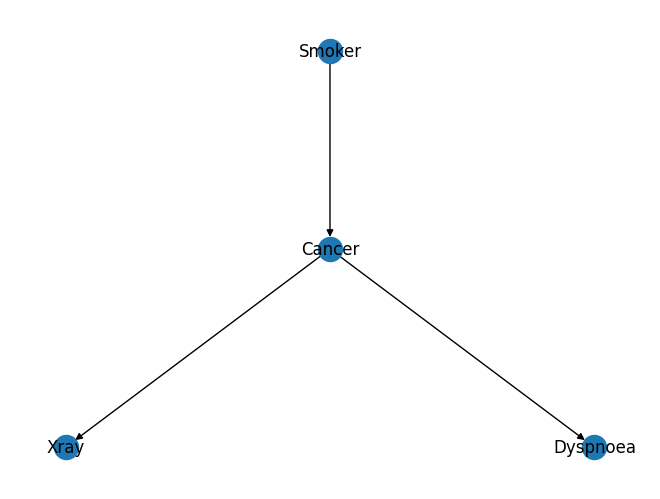

In [7]:
drawGraph(BNmodel)